In [5]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.integrate import odeint
import sys
current_dir = os.path.dirname(os.getcwd())
target_dir = os.path.sep.join(current_dir.split(os.path.sep)[:])
sys.path.append(os.path.join(os.path.dirname(target_dir),'eABCSMC'))
sys.path.append(os.path.join(os.getcwd(),'Examples_Chaos'))
sys.path.append(target_dir)
from Models import *
from EABCSMC import *
from Preconditioning import * 
import time



In [6]:
"""
%%capture
from Datagetter import *
path ='../Data/COVID-19.RData'
spain = get_data(path = path, country_code = 'ES', start_date = '2020-02-24', end_date = '2020-12-25', source = 'JHU', model = 'SIRD', rdata = True)
"""

"\n%%capture\nfrom Datagetter import *\npath ='../Data/COVID-19.RData'\nspain = get_data(path = path, country_code = 'ES', start_date = '2020-02-24', end_date = '2020-12-25', source = 'JHU', model = 'SIRD', rdata = True)\n"

In [7]:
spain = pd.read_csv('../Data/Sird_Spain.csv')
spain.fillna(0, inplace = True)

Precond = Preconditioner(SIRD_reduced_30_new)

Precond.preprocess_data(data=spain, start=10, eff=30, ext=150)

In [8]:
popt, pcov = Precond.fit(p0 = (0.1, 0.1, 10, 0.1), bounds=([0, 0, 0, 0], [3, 7, 100000, 3]))

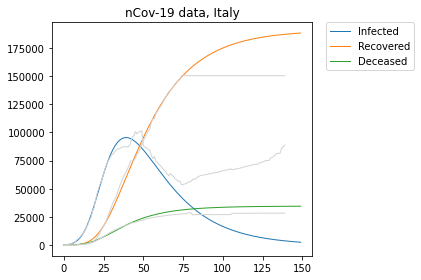

In [9]:
simul_yy =  odeint(SIRD_reduced_30_new, (254.,   3.  , 2.), np.arange(150), args=tuple(np.reshape(popt,(1,-1))[0]))
plot_traj_SIRD(simul_yy)
plot_traj_gray_SIRD(Precond.extended_y)

In [10]:
lambda_ranges = [lambda: npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5),
                 lambda: npr.uniform(low = 10, high = 20)]
prior_means =  np.array([ 0.28802481,  0.03922435,  10,  0.06892933])

Sampler = EABCSMCSampler(true_y = Precond.true_yy, ODEmodel = Precond.fit_odeint, num_param = len(popt), numerical_estimate = popt, final_time = 30, 
                         lambda_ranges = lambda_ranges, prior_means = prior_means, n_jobs = 3)

  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]

Borders estimation start...


  0%|▏                                                                             | 66/30000 [00:00<00:52, 575.44it/s]

Acceptance rate:  0.009066666666666667
Borders estimation completed, starting preprocessing...
Borders: [0.44218700686702694, 0.01905343466959109, 3.231639366878457, 0.07148046804854472]


  0%|                                                                              | 42/30000 [00:00<01:13, 404.93it/s]

Acceptance rate:  0.0044
Preprocessing completed, starting ABC-SMC


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:19<00:00, 376.80it/s]


Acceptance rate:  0.0376


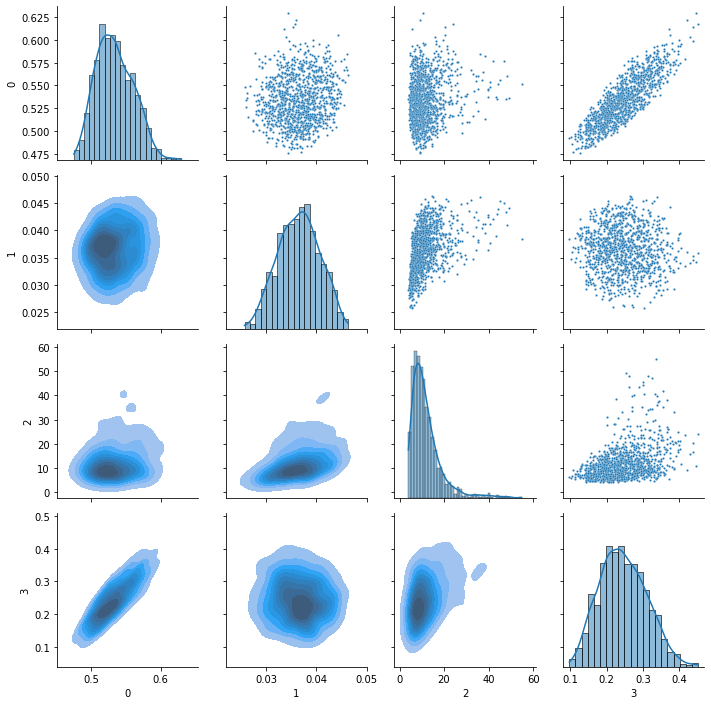

In [11]:
Sampler.fit(niters=3000, eps_schedule=[1, 1/2, 1/3], niters_schedule=[10, 10, 10])
Sampler.pairplot()

In [12]:
parameters = Sampler.parameters

In [13]:
def plot_traj_SIRD(trajectories, width=1.5):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]

    i = plt.plot(x2, linewidth=width, label='Infected', color = 'navy')
    r = plt.plot(x3, linewidth=width, label='Recovered', color = (.21,.39,.55))
    d = plt.plot(x4, linewidth=width, label='Deceased', color = (0.39,.72,1))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.title('Real SIRD')
    plt.title('SIRD prediction at day 30')
    plt.tight_layout()
    
def plot_traj_SIRD2(trajectories, width=.7):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]
    color_ = (0,0,0.5)
    

    i = plt.plot(x2, linewidth=width,color = 'navy', linestyle = 'dashed' )
    r = plt.plot(x3, linewidth=width, color = (.21,.39,.55), linestyle = 'dashed')
    d = plt.plot(x4, linewidth=width,  color = (0.39,.72,1), linestyle = 'dashed')

    # plt.title('Real SIRD')
    plt.tight_layout()

76460.26190463858 117610.94477013296
37.0 46.0
49
101617.0


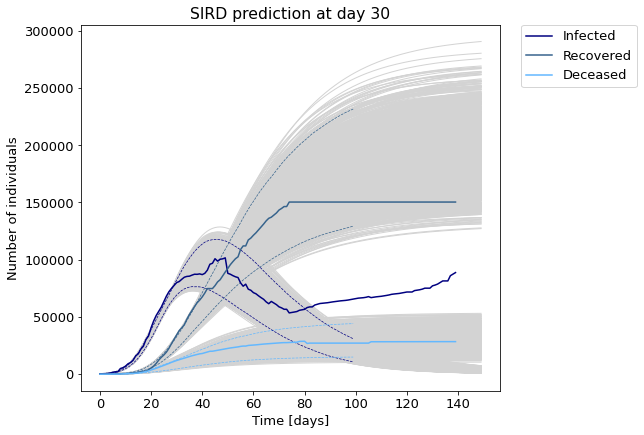

In [14]:
# magari anche questo lo metto dentro all'abc sampler

fig = plt.figure(figsize = (9,6))

plt.rcParams.update({'font.size': 13})

peak = []
day_peak = []
simul_all = []

for j in range(parameters.shape[0]):
    simul_yy =  odeint(SIRD_reduced_30_new, [221,1,7], np.arange(150), args=tuple(parameters[j]))
    simul_all.append(simul_yy)
    plot_traj_gray_SIRD(simul_yy)
    peak.append(max(simul_yy[:,0]))
    day_peak.append(np.argmax(simul_yy[:,0])) 

simul_all = np.array(simul_all)
q95 = []
q05 = []
mean = []
sd = []
for i in range(100):
    q95.append([np.quantile(simul_all[:,i,0],0.975),np.quantile(simul_all[:,i,1],0.975),np.quantile(simul_all[:,i,2],0.975)])
    q05.append([np.quantile(simul_all[:,i,0],0.025),np.quantile(simul_all[:,i,1],0.025),np.quantile(simul_all[:,i,2],0.025)])
    mean.append([np.mean(simul_all[:,i,0]),np.mean(simul_all[:,i,1]),np.mean(simul_all[:,i,2])])
    sd.append([np.std(simul_all[:,i,0]),np.std(simul_all[:,i,1]),np.std(simul_all[:,i,2])])

q95 = np.array(q95)    
q05 = np.array(q05)   
    
plot_traj_SIRD2(q95)

plot_traj_SIRD2(q05)

plot_traj_SIRD(Precond.extended_y)

print(np.quantile(peak,0.025), np.quantile(peak,0.975))
print(np.quantile(day_peak,0.025), np.quantile(day_peak,0.975))
print(np.argmax(Precond.extended_y[:,0]))
print(np.max(Precond.extended_y[:,0]))

plt.ylabel('Number of individuals')
plt.xlabel('Time [days]')
plt.show()


5 9


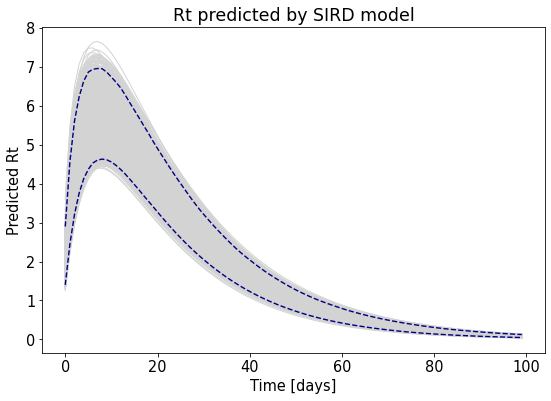

<Figure size 432x288 with 0 Axes>

In [15]:
t = np.arange(100)

fig = plt.figure(figsize = (9,6))
plt.rcParams.update({'font.size': 14.5})

day_max = []
rt = []
for j in range(parameters.shape[0]):
    rt.append(parameters[j,0]* np.exp(-(9.72588371e-02 * parameters[j,0]) * t)/((parameters[j,3]/(t+1)) + parameters[j,1]))
    plt.plot(t, parameters[j,0]* np.exp(-(9.72588371e-02 * parameters[j,0]) * t)/((parameters[j,3]/(t+1)) + parameters[j,1]), linewidth = 1, color = 'lightgray')
    day_max.append(np.argmax(parameters[j,0]* np.exp(-(1.713e-2 + 7.094e-02 * parameters[j,0]) * t)/((parameters[j,3]/(t+1)) + parameters[j,1])))

rt = np.array(rt)

rt95 = []
rt05 = []
for i in range(100):
    rt95.append(np.quantile(rt[:,i],0.975))
    rt05.append(np.quantile(rt[:,i],0.025))
    
plt.plot(rt95, linewidth=1.4,color = 'navy', linestyle = 'dashed')
plt.plot(rt05, linewidth=1.4,color = 'navy', linestyle = 'dashed')

print(min(day_max), max(day_max))  
plt.title('Rt predicted by SIRD model')
plt.ylabel('Predicted Rt')
plt.xlabel('Time [days]')
plt.figure();